# Calculating Utilizations for Plates and Plotting with ``PyVista``

We will calculate deflections, strains, internal forces, stresses and utilizations for a Mindlin plate. We are also going to visualize the stresses using PyVista.

In [4]:
import numpy as np

from sigmaepsilon.math.linalg import ReferenceFrame

from sigmaepsilon.solid.material import MindlinPlateSection as Section
from sigmaepsilon.solid.material import (
    ElasticityTensor,
    LinearElasticMaterial,
    HuberMisesHenckyFailureCriterion_SP,
)
from sigmaepsilon.solid.material.utils import elastic_stiffness_matrix

from sigmaepsilon.solid.fourier import (
    NavierPlate,
    LoadGroup,
    PointLoad,
    RectangleLoad,
)

# geometry
length_X, length_Y = (600.0, 800.0)
thickness = 25.0

# material properties
young_modulus = 2890.0
poisson_ratio = 0.2
yield_strength = 2.0

# solution parameters
number_of_modes_X = 20
number_of_modes_Y = 20

# setting up hooke's law
hooke = elastic_stiffness_matrix(E=young_modulus, NU=poisson_ratio)
frame = ReferenceFrame(dim=3)
stiffness = ElasticityTensor(hooke, frame=frame, tensorial=False)
failure_model = HuberMisesHenckyFailureCriterion_SP(yield_strength=yield_strength)
material = LinearElasticMaterial(stiffness=stiffness, failure_model=failure_model)

# section stiffness
section = Section(
    layers=[
        Section.Layer(material=material, thickness=thickness),
    ]
)
ABDS_matrix = section.elastic_stiffness_matrix()
bending_stiffness, shear_stiffness = (
    np.ascontiguousarray(ABDS_matrix[:3, :3]),
    np.ascontiguousarray(ABDS_matrix[3:, 3:]),
)

# set up loads
loads = LoadGroup(
    LG1=LoadGroup(
        LC1=RectangleLoad([[0, 0], [length_X, length_Y]], [-0.1, 0, 0]),
        LC2=RectangleLoad(
            [[length_X / 3, length_Y / 2], [length_X / 2, 2 * length_Y / 3]],
            [-1, 0, 0],
        ),
    ),
    LG2=LoadGroup(
        LC3=PointLoad([length_X / 3, length_Y / 2], [-100.0, 0, 0]),
        LC4=PointLoad([2 * length_X / 3, length_Y / 2], [100.0, 0, 0]),
    ),
)
loads.lock()  # freezes the layout to protect agains typos

#nx, ny = (240, 320)  # for higher resolution
nx, ny = (150, 200)
x = np.linspace(0, length_X, nx)
y = np.linspace(0, length_Y, ny)
xv, yv = np.meshgrid(x, y)
evaluation_points = np.stack((xv.flatten(), yv.flatten()), axis=1)

plate = NavierPlate(
    (length_X, length_Y),
    (number_of_modes_X, number_of_modes_Y),
    D=bending_stiffness,
    S=shear_stiffness,
)
results = plate.linear_static_analysis(evaluation_points, loads)

## Plotting as a PointCloud with ``PyVista``

In [5]:
import pyvista as pv

load_case_results = results["LG1", "LC2"].values
strains = load_case_results[:, 3:8]
z = np.linspace(-thickness / 2, thickness / 2, 20)
rng = (-thickness / 2, thickness / 2)
util, util_coords = section.utilization(
    strains=strains, rng=rng, z=z, coords=evaluation_points, return_coords=True
)

num_XY, num_Z = util_coords.shape[:2]
util_coords = util_coords.reshape((num_XY * num_Z, 3))
util = util.values.flatten()

point_cloud = pv.PolyData(util_coords)
point_cloud["scalars"] = util

point_cloud

PolyData (0x3227048e0)
  N Cells:    600000
  N Points:   600000
  N Strips:   0
  X Bounds:   0.000e+00, 6.000e+02
  Y Bounds:   0.000e+00, 8.000e+02
  Z Bounds:   -1.250e+01, 1.250e+01
  N Arrays:   1

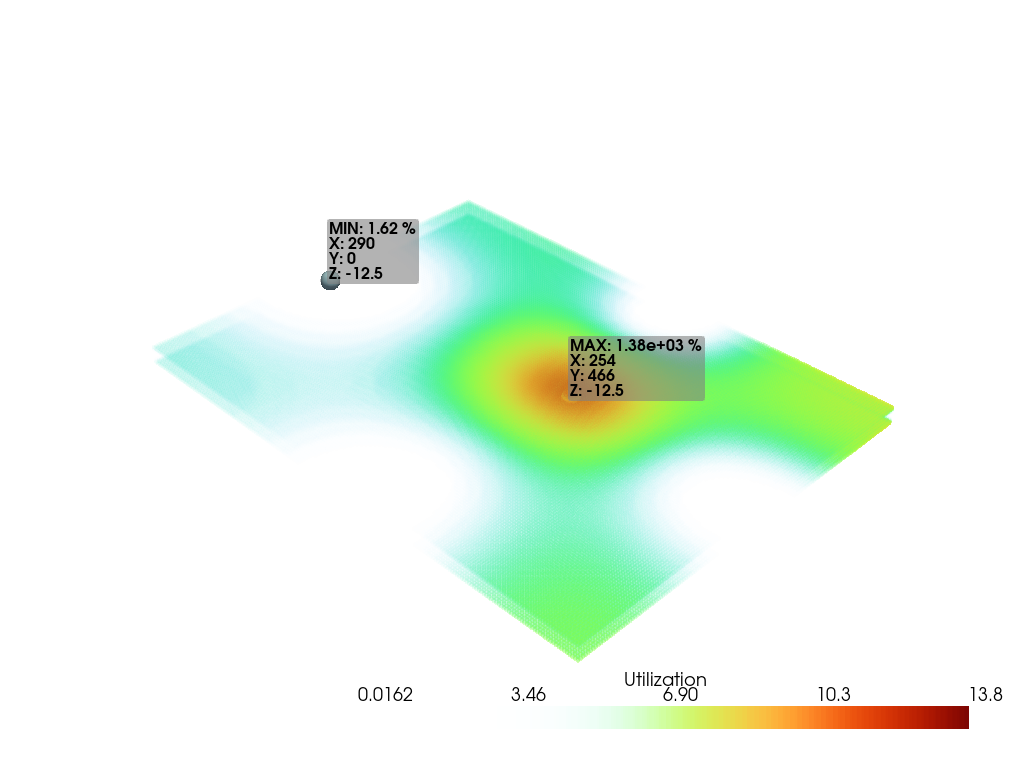

In [6]:
from sigmaepsilon.core.formatting import floatformatter

formatter = floatformatter(sig=3)  # to format strings to 3 significant digits

plotter = pv.Plotter(notebook=True)

scalars = util
points = util_coords
max_index = np.argmax(scalars)
min_index = np.argmin(scalars)

p_min = point_cloud.points[min_index]
p_max = point_cloud.points[max_index]
label_coords = np.array([p_min, p_max])

labels = [
    (
        f"MIN: {formatter.format(util.min()*100)} %"
        f"\nX: {formatter.format(points[min_index, 0])}"
        f"\nY: {formatter.format(points[min_index, 1])}"
        f"\nZ: {formatter.format(points[min_index, 2])}"
    ),
    (
        f"MAX: {formatter.format(util.max()*100)} %"
        f"\nX: {formatter.format(points[max_index, 0])}"
        f"\nY: {formatter.format(points[max_index, 1])}"
        f"\nZ: {formatter.format(points[max_index, 2])}"
    ),
]

plotter.add_mesh(
    point_cloud,
    scalars="scalars",
    cmap="turbo",
    lighting=False,
    scalar_bar_args={"title": "Utilization"},
    render_points_as_spheres=True,
    opacity="sigmoid",
)

plotter.add_point_labels(
    label_coords,
    labels,
    point_size=20,
    font_size=16,
    always_visible=True,
    shape_color="grey",
    shape_opacity=0.6,
    render_points_as_spheres=True,
)

plotter.show(jupyter_backend="static")